In [1]:
import pandas as pd
import glob
import os
import numpy as np
import sys
! pip install pmcx
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
from pathlib import Path
import os, re

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 3.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MCX_data'
sys.path.append(folder_path)
from FD_msNIRS_2layers import extract_freq as ef

Mounted at /content/drive


### Single SD

In [34]:
import os, re
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

def compute_fd_td_metrics(folder_path):
    # mapping from file‐index (1…8) → actual S‑D distance (mm)
    sd_map = {i+1: dist for i, dist in enumerate([10, 15, 20, 25, 30, 35, 40, 45])}

    fd_metrics = {}
    td_metrics = {}

    # still match on "distance_{1…8}_hhb2_{TD|FD}.csv"
    pattern = re.compile(r'distance_(\d+)_hhb2_(TD|FD)\.csv', re.IGNORECASE)

    for fname in os.listdir(folder_path):
        m = pattern.match(fname)
        if not m:
            continue

        idx    = int(m.group(1))          # 1…8
        dist   = sd_map[idx]              # e.g. 1→10, 2→15, …, 8→45
        domain = m.group(2).upper()
        path   = os.path.join(folder_path, fname)

        df     = pd.read_csv(path)
        y_pred = df['y_pred'].to_numpy()
        y_true = df['y_test'].to_numpy()

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mare = np.mean(np.abs(y_pred - y_true) / np.abs(y_true)) * 100

        entry = {'MARE(%)': mare, 'RMSE': rmse}

        if domain == 'FD':
            fd_metrics[dist] = entry
        else:
            td_metrics[dist] = entry

    # sort by the actual distance keys
    fd_metrics = dict(sorted(fd_metrics.items()))
    td_metrics = dict(sorted(td_metrics.items()))

    return fd_metrics, td_metrics

# usage
folder = '/content/drive/MyDrive/MCX_data/distance_1/'
fd_metrics, td_metrics = compute_fd_td_metrics(folder)

print("Frequency‑Domain Metrics:")
for dist, mets in fd_metrics.items():
    print(f"  {dist} mm → MARE={mets['MARE(%)']:.4f}%, RMSE={mets['RMSE']:.4f}")

print("\nTime‑Domain Metrics:")
for dist, mets in td_metrics.items():
    print(f"  {dist} mm → MARE={mets['MARE(%)']:.4f}%, RMSE={mets['RMSE']:.4f}")


Frequency‑Domain Metrics:
  10 mm → MARE=18.2786%, RMSE=5.0476
  15 mm → MARE=16.6249%, RMSE=4.7767
  20 mm → MARE=16.4030%, RMSE=4.5615
  25 mm → MARE=16.6459%, RMSE=4.5980
  30 mm → MARE=15.7848%, RMSE=4.5435
  35 mm → MARE=15.7421%, RMSE=4.4597
  40 mm → MARE=16.1386%, RMSE=4.5877
  45 mm → MARE=16.2113%, RMSE=4.6827

Time‑Domain Metrics:
  10 mm → MARE=5.0252%, RMSE=1.7374
  15 mm → MARE=5.4877%, RMSE=1.8644
  20 mm → MARE=5.1223%, RMSE=1.6983
  25 mm → MARE=5.4350%, RMSE=1.7780
  30 mm → MARE=5.2375%, RMSE=1.7045
  35 mm → MARE=5.9674%, RMSE=1.9659
  40 mm → MARE=5.7404%, RMSE=1.9246
  45 mm → MARE=6.8539%, RMSE=2.1569


In [25]:
import matplotlib.pyplot as plt

def plot_fd_td_metrics(fd_metrics, td_metrics):
    # sort distances
    d_fd = sorted(fd_metrics.keys())
    d_td = sorted(td_metrics.keys())

    # extract series
    mare_fd = [fd_metrics[d]['MARE(%)'] for d in d_fd]
    rmse_fd = [fd_metrics[d]['RMSE']     for d in d_fd]

    mare_td = [td_metrics[d]['MARE(%)'] for d in d_td]
    rmse_td = [td_metrics[d]['RMSE']     for d in d_td]

    fig, (ax_td, ax_fd) = plt.subplots(1, 2, figsize=(12, 5))

    # --- Time‑Domain subplot with twin y-axis ---
    ax1 = ax_td
    ax2 = ax1.twinx()
    l1 = ax1.plot(d_td, mare_td, color='tab:blue',  marker='o', label='MARE (%)')
    l2 = ax2.plot(d_td, rmse_td, color='tab:red',   marker='s', label=r'RMSE ($\mu$M)')
    ax1.set_xlabel('S‑D Distance (mm)')
    ax1.set_ylabel('MARE (%)', color='tab:blue')
    ax2.set_ylabel(r'RMSE ($\mu$M)',     color='tab:red')
    #ax1.set_title('Time‑Domain Metrics')
    # combine legends
    lines = l1 + l2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best')
    ax1.grid(True)

    # --- Frequency‑Domain subplot with twin y-axis ---
    ax3 = ax_fd
    ax4 = ax3.twinx()
    l3 = ax3.plot(d_fd, mare_fd, color='tab:green', marker='o', label='MARE (%)')
    l4 = ax4.plot(d_fd, rmse_fd, color='tab:purple', marker='s', label=r'RMSE ($\mu$M)')
    ax3.set_xlabel('S‑D Distance (mm)')
    ax3.set_ylabel('MARE (%)', color='tab:green')
    ax4.set_ylabel(r'RMSE ($\mu$M)',     color='tab:purple')
    #ax3.set_title('Frequency‑Domain Metrics')
    lines = l3 + l4
    labels = [l.get_label() for l in lines]
    ax3.legend(lines, labels, loc='best')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

In [28]:
import matplotlib.pyplot as plt

def plot_fd_td_metrics(fd_metrics, td_metrics):
    # sort distances
    d_fd = sorted(fd_metrics.keys())
    d_td = sorted(td_metrics.keys())

    # extract series
    mare_fd = [fd_metrics[d]['MARE(%)'] for d in d_fd]
    rmse_fd = [fd_metrics[d]['RMSE']     for d in d_fd]
    mare_td = [td_metrics[d]['MARE(%)'] for d in d_td]
    rmse_td = [td_metrics[d]['RMSE']     for d in d_td]

    fig, (ax_td, ax_fd) = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

    # --- Time‑Domain subplot --- #
    ax1 = ax_td
    ax2 = ax1.twinx()
    l1 = ax1.plot(d_td, mare_td, marker='o', lw=2, ms=6, label='MARE (%)', color='tab:blue')
    l2 = ax2.plot(d_td, rmse_td, marker='s', lw=2, ms=6, label=r'RMSE ($\mu$M)', color='tab:red')

    ax1.set_xlabel('S‑D Distance (mm)', fontsize=8)
    ax1.set_ylabel('MARE (%)', color='tab:blue', fontsize=12)
    ax2.set_ylabel(r'RMSE ($\mu$M)', color='tab:red', fontsize=12)

    # remove top/right spines and enlarge tick labels
    for ax in (ax1, ax2):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(labelsize=10)

    lines = l1 + l2
    labels = [ln.get_label() for ln in lines]
    ax1.legend(lines, labels, loc='upper left', fontsize=10)
    ax1.grid(True)

    # --- Frequency‑Domain subplot --- #
    ax3 = ax_fd
    ax4 = ax3.twinx()
    l3 = ax3.plot(d_fd, mare_fd, marker='o', lw=2, ms=6, label='MARE (%)', color='tab:green')
    l4 = ax4.plot(d_fd, rmse_fd, marker='s', lw=2, ms=6, label=r'RMSE ($\mu$M)', color='tab:purple')

    ax3.set_xlabel('S‑D Distance (mm)', fontsize=8)
    ax3.set_ylabel('MARE (%)', color='tab:green', fontsize=12)
    ax4.set_ylabel(r'RMSE ($\mu$M)', color='tab:purple', fontsize=12)

    # remove top/right spines and enlarge tick labels
    for ax in (ax3, ax4):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(labelsize=10)

    lines = l3 + l4
    labels = [ln.get_label() for ln in lines]
    ax3.legend(lines, labels, loc='upper left', fontsize=10)
    ax3.grid(True)

    plt.tight_layout()
    plt.show()


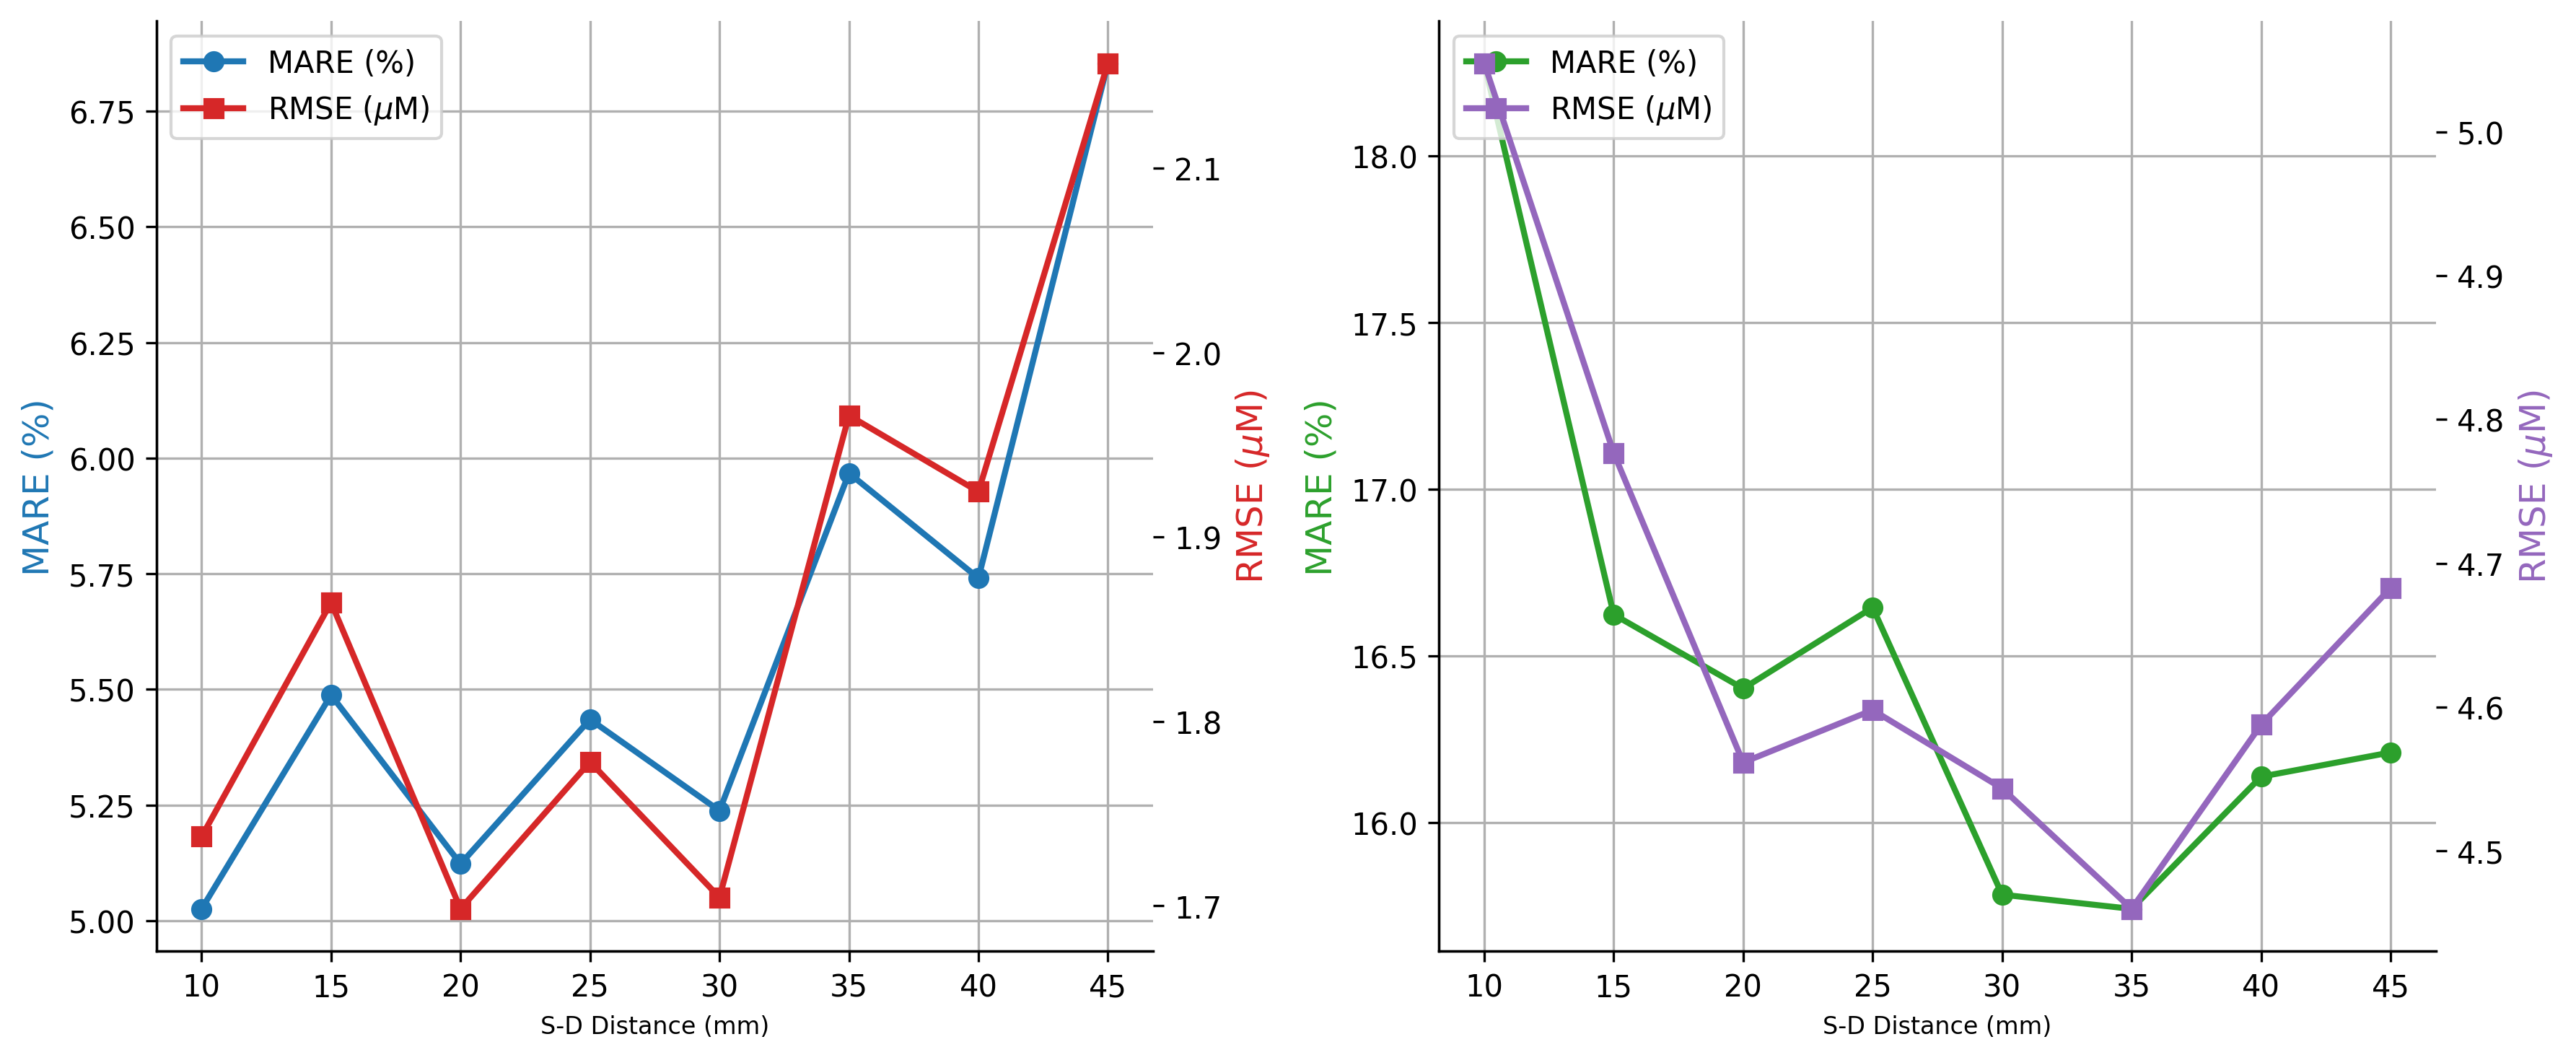

In [29]:
plot_fd_td_metrics(fd_metrics, td_metrics)

### Many SD

In [36]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

def compute_fd_td_metrics_all(folder_path: str):
    """
    Reads all CSVs named distance_{key}_hhb2_{FD|TD}.csv in folder_path,
    computes MARE(%) and RMSE for each, and returns two dicts:
      • fd_metrics[key] = {'MARE(%)': ..., 'RMSE': ...}
      • td_metrics[key] = {'MARE(%)': ..., 'RMSE': ...}
    where key is the integer parsed from the filename (e.g. 123, 1234, …).
    """
    fd_metrics = {}
    td_metrics = {}

    # match distance_<digits>_hhb2_<FD or TD>.csv
    pattern = re.compile(r'distance_(\d+)_hhb2_(FD|TD)\.csv', re.IGNORECASE)

    for fname in os.listdir(folder_path):
        m = pattern.match(fname)
        if not m:
            continue

        key    = int(m.group(1))       # e.g. 123, 1234, etc.
        domain = m.group(2).upper()    # 'FD' or 'TD'
        path   = os.path.join(folder_path, fname)

        # load predictions & ground truth
        df     = pd.read_csv(path)
        y_pred = df['y_pred'].to_numpy()
        y_true = df['y_test'].to_numpy()

        # compute metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mare = np.mean(np.abs(y_pred - y_true) / np.abs(y_true)) * 100

        entry = {'MARE(%)': mare, 'RMSE': rmse}
        if domain == 'FD':
            fd_metrics[key] = entry
        else:
            td_metrics[key] = entry

    # sort by key
    fd_metrics = dict(sorted(fd_metrics.items()))
    td_metrics = dict(sorted(td_metrics.items()))

    return fd_metrics, td_metrics


In [37]:
folder = '/content/drive/MyDrive/MCX_data/distance_all/'
fd_metrics, td_metrics = compute_fd_td_metrics_all(folder)
td_metrics[12345678] = {'MARE(%)': np.float64(2.614),
 'RMSE': np.float64(0.638)}
td_metrics[12] = {'MARE(%)': np.float64(3.72),
 'RMSE': np.float64(1.3343)}
##
fd_metrics[12345678] = {'MARE(%)': np.float64(7.262),
 'RMSE': np.float64(1.712)}
fd_metrics[12] = {'MARE(%)': np.float64(13.03),
 'RMSE': np.float64(3.7912)}

print("Frequency‑Domain Metrics:")
for key in sorted(fd_metrics, key=lambda k: (len(str(k)), k)):
    m = fd_metrics[key]
    print(f"  {key}: MARE={m['MARE(%)']:.4f}%, RMSE={m['RMSE']:.4f}")

print("\nTime‑Domain Metrics:")
for key in sorted(td_metrics, key=lambda k: (len(str(k)), k)):
    m = td_metrics[key]
    print(f"  {key}: MARE={m['MARE(%)']:.4f}%, RMSE={m['RMSE']:.4f}")

Frequency‑Domain Metrics:
  12: MARE=13.0300%, RMSE=3.7912
  123: MARE=10.7465%, RMSE=3.2574
  1234: MARE=8.1554%, RMSE=2.6607
  12345: MARE=8.5006%, RMSE=2.6726
  123456: MARE=7.7123%, RMSE=2.2561
  1234567: MARE=6.6986%, RMSE=2.0201
  12345678: MARE=7.2620%, RMSE=1.7120

Time‑Domain Metrics:
  12: MARE=3.7200%, RMSE=1.3343
  123: MARE=3.3106%, RMSE=1.2798
  1234: MARE=3.0528%, RMSE=1.1481
  12345: MARE=2.7192%, RMSE=1.0538
  123456: MARE=3.0801%, RMSE=1.0576
  1234567: MARE=2.8954%, RMSE=1.0543
  12345678: MARE=2.6140%, RMSE=0.6380


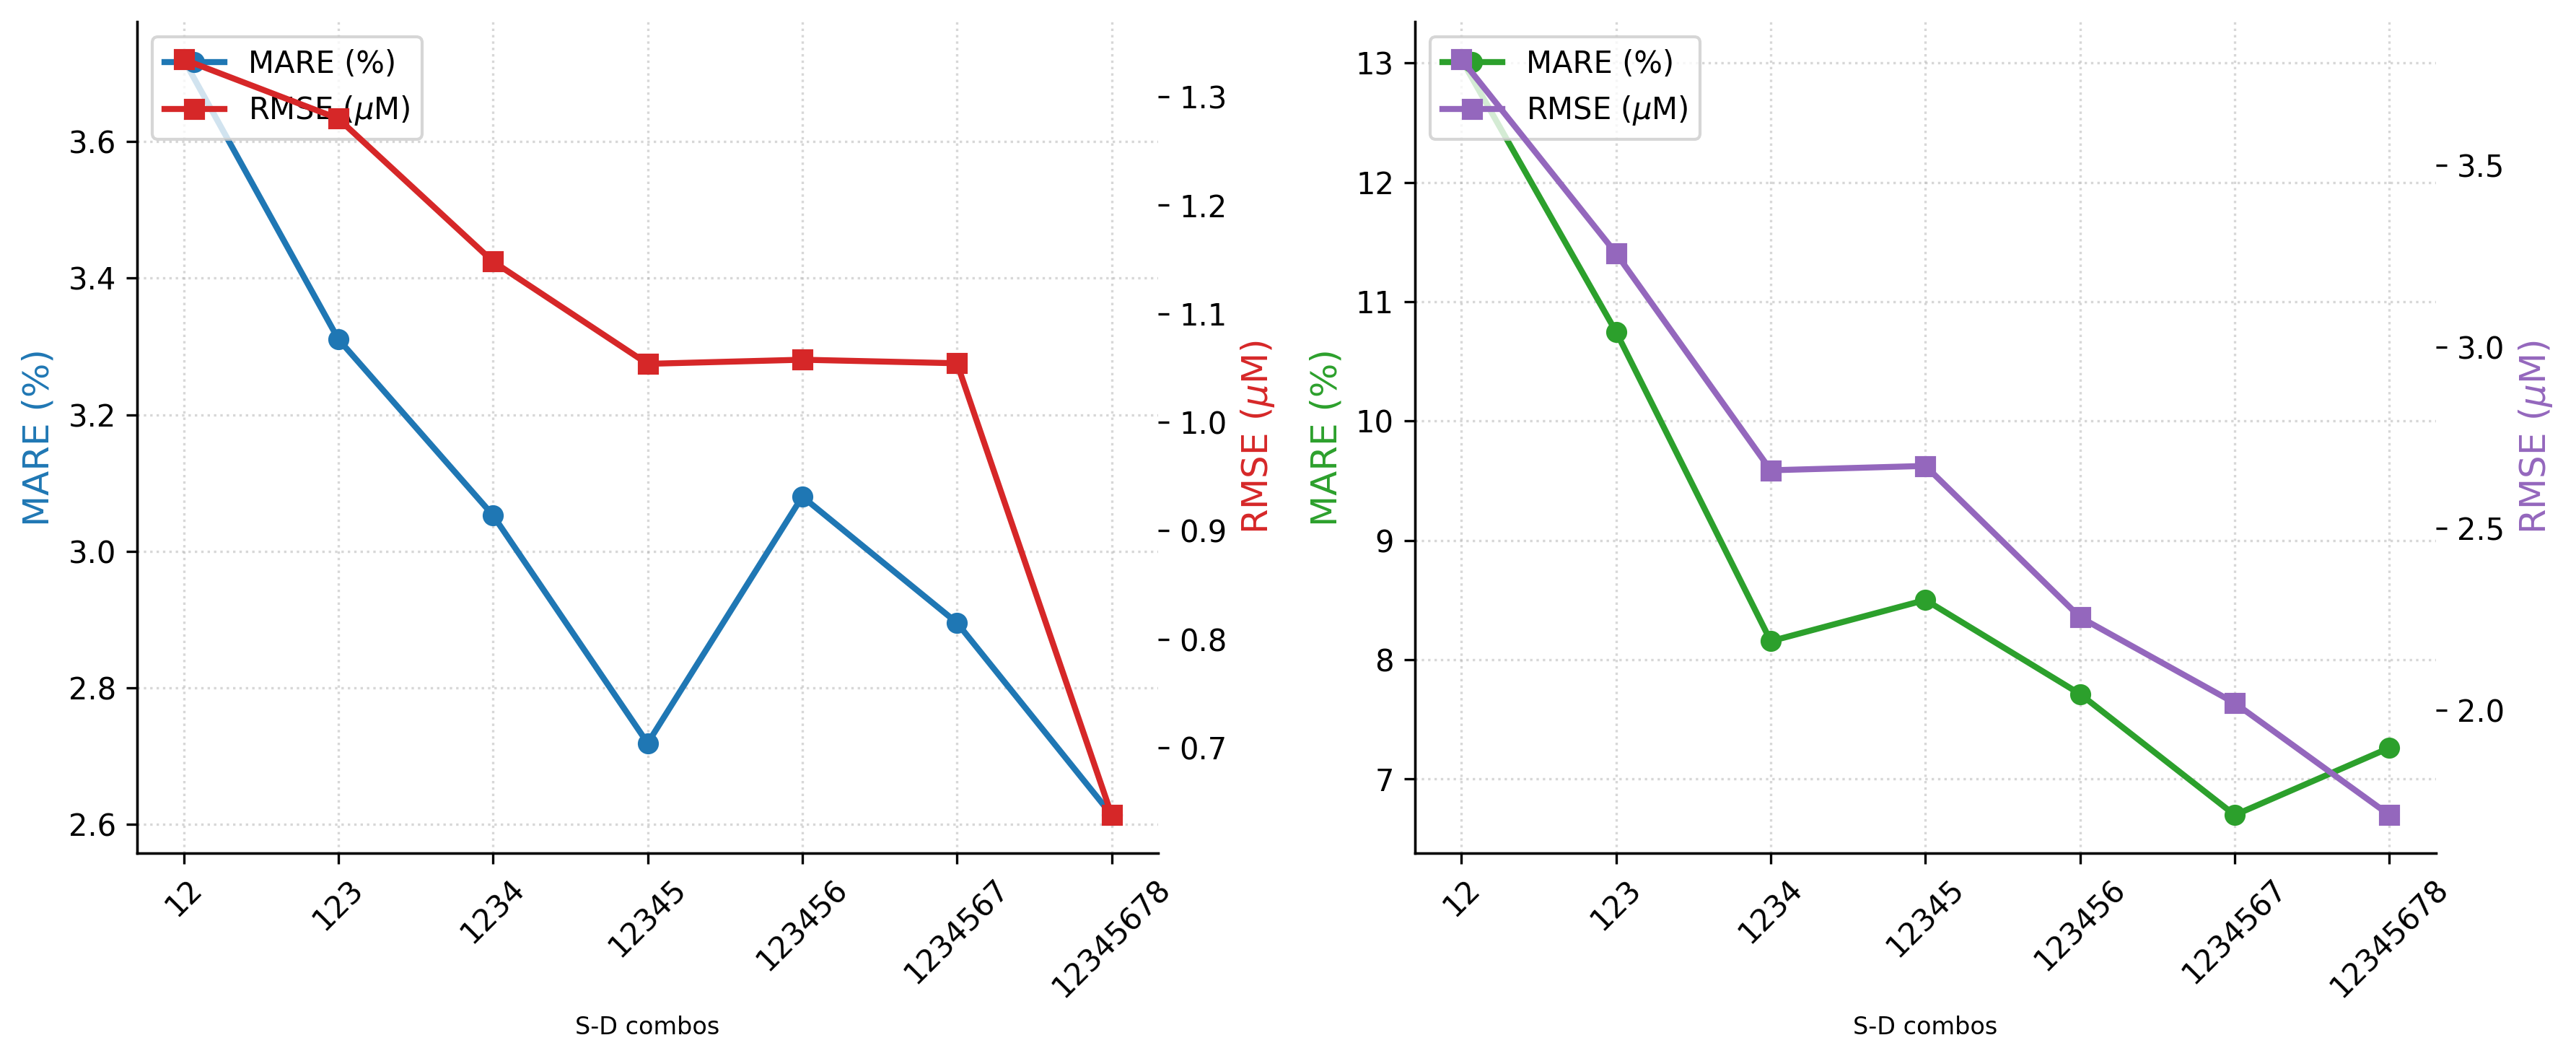

In [38]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_fd_td_line(metrics_fd, metrics_td):
    """
    Side‑by‑side slope plots of MARE and RMSE vs. dictionary key.
    Removes both top and right spines on all axes.
    """
    # prepare sorted keys & labels
    keys_td = sorted(metrics_td.keys(), key=lambda k: (len(str(k)), k))
    keys_fd = sorted(metrics_fd.keys(), key=lambda k: (len(str(k)), k))
    labels_td = [str(k) for k in keys_td]
    labels_fd = [str(k) for k in keys_fd]
    x_td = list(range(len(keys_td)))
    x_fd = list(range(len(keys_fd)))

    # extract metric series
    mare_td = [metrics_td[k]['MARE(%)'] for k in keys_td]
    rmse_td = [metrics_td[k]['RMSE']     for k in keys_td]
    mare_fd = [metrics_fd[k]['MARE(%)']  for k in keys_fd]
    rmse_fd = [metrics_fd[k]['RMSE']     for k in keys_fd]

    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

    # Time‑Domain subplot
    ax1_t = ax1.twinx()
    # remove top & right spines
    for ax in (ax1, ax1_t):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    l1 = ax1.plot(x_td, mare_td, marker='o', lw=2, ms=6,
                  color='tab:blue', label='MARE (%)')
    l2 = ax1_t.plot(x_td, rmse_td, marker='s', lw=2, ms=6,
                   color='tab:red', label=r'RMSE ($\mu$M)')

    #ax1.set_title('Time‑Domain Metrics', fontsize=14)
    ax1.set_xlabel('S-D combos', fontsize=8)
    ax1.set_xticks(x_td)
    ax1.set_xticklabels(labels_td, rotation=45, fontsize=10)
    ax1.set_ylabel('MARE (%)', color='tab:blue', fontsize=12)
    ax1_t.set_ylabel(r'RMSE ($\mu$M)', color='tab:red', fontsize=12)
    ax1.grid(True, linestyle=':', alpha=0.5)

    # combined legend
    lines = l1 + l2
    labels = [ln.get_label() for ln in lines]
    ax1.legend(lines, labels, loc='upper left', fontsize=10)


    # Frequency‑Domain subplot
    ax3_t = ax3.twinx()
    for ax in (ax3, ax3_t):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    l3 = ax3.plot(x_fd, mare_fd, marker='o', lw=2, ms=6,
                  color='tab:green', label='MARE (%)')
    l4 = ax3_t.plot(x_fd, rmse_fd, marker='s', lw=2, ms=6,
                   color='tab:purple', label=r'RMSE ($\mu$M)')

    #ax3.set_title('Frequency‑Domain Metrics', fontsize=14)
    ax3.set_xlabel('S-D combos', fontsize=8)
    ax3.set_xticks(x_fd)
    ax3.set_xticklabels(labels_fd, rotation=45, fontsize=10)
    ax3.set_ylabel('MARE (%)', color='tab:green', fontsize=12)
    ax3_t.set_ylabel(r'RMSE ($\mu$M)', color='tab:purple', fontsize=12)
    ax3.grid(True, linestyle=':', alpha=0.5)

    lines = l3 + l4
    labels = [ln.get_label() for ln in lines]
    ax3.legend(lines, labels, loc='upper left', fontsize=10)

    plt.tight_layout()
    plt.show()


plot_fd_td_line(fd_metrics, td_metrics)

### 2 SD

In [8]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

def compute_fd_td_metrics(folder_path: str):
    """
    Reads all CSVs named distance_<key>_hhb2_<FD|TD>.csv in folder_path,
    computes MARE(%) and RMSE for each, and returns two dicts:
      • fd_metrics[key] = {'MARE(%)': ..., 'RMSE': ...}
      • td_metrics[key] = {'MARE(%)': ..., 'RMSE': ...}
    where key is the integer parsed from the filename (e.g. 12, 13, 14…).
    """
    fd_metrics = {}
    td_metrics = {}

    pattern = re.compile(r'distance_(\d+)_hhb2_(FD|TD)\.csv', re.IGNORECASE)

    for fname in os.listdir(folder_path):
        m = pattern.match(fname)
        if not m:
            continue

        key    = int(m.group(1))      # e.g. 12, 13, …
        domain = m.group(2).upper()   # 'FD' or 'TD'
        path   = os.path.join(folder_path, fname)

        df     = pd.read_csv(path)
        y_pred = df['y_pred'].to_numpy()
        y_true = df['y_test'].to_numpy()

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mare = np.mean(np.abs(y_pred - y_true) / np.abs(y_true)) * 100

        entry = {'MARE(%)': mare, 'RMSE': rmse}
        if domain == 'FD':
            fd_metrics[key] = entry
        else:
            td_metrics[key] = entry

    # sort by key before returning
    fd_metrics = dict(sorted(fd_metrics.items()))
    td_metrics = dict(sorted(td_metrics.items()))
    return fd_metrics, td_metrics

In [9]:

folder = '/content/drive/MyDrive/MCX_data/distance_2/'

fd_metrics, td_metrics = compute_fd_td_metrics(folder)

print("Frequency‑Domain Metrics (FD):")
for key, mets in fd_metrics.items():
        print(f"  distances {key}: MARE={mets['MARE(%)']:.2f}%, RMSE={mets['RMSE']:.4f}")

print("\nTime‑Domain Metrics (TD):")
for key, mets in td_metrics.items():
        print(f"  distances {key}: MARE={mets['MARE(%)']:.2f}%, RMSE={mets['RMSE']:.4f}")

Frequency‑Domain Metrics (FD):
  distances 12: MARE=13.03%, RMSE=3.7912
  distances 13: MARE=12.23%, RMSE=3.5494
  distances 14: MARE=10.77%, RMSE=3.1504
  distances 15: MARE=9.45%, RMSE=2.8913
  distances 16: MARE=9.92%, RMSE=3.0093
  distances 17: MARE=9.39%, RMSE=2.9045
  distances 18: MARE=10.83%, RMSE=3.1422
  distances 23: MARE=12.37%, RMSE=3.6514
  distances 24: MARE=11.27%, RMSE=3.3718
  distances 25: MARE=10.62%, RMSE=3.2591
  distances 26: MARE=9.78%, RMSE=2.9974
  distances 27: MARE=10.05%, RMSE=3.0616
  distances 28: MARE=9.53%, RMSE=2.8688
  distances 34: MARE=12.31%, RMSE=3.6919
  distances 35: MARE=10.57%, RMSE=3.1838
  distances 36: MARE=9.70%, RMSE=2.8713
  distances 37: MARE=10.10%, RMSE=3.0467
  distances 38: MARE=10.03%, RMSE=3.0928
  distances 45: MARE=11.91%, RMSE=3.5360
  distances 46: MARE=10.40%, RMSE=3.1209
  distances 47: MARE=10.32%, RMSE=3.0983
  distances 48: MARE=11.02%, RMSE=3.1956
  distances 56: MARE=12.97%, RMSE=3.7493
  distances 57: MARE=12.03%, RMS

In [41]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.metrics import mean_squared_error

def compute_fd_td_metrics(folder_path):
    fd, td = {}, {}
    pat = re.compile(r'distance_(\d+)_hhb2_(FD|TD)\.csv', re.IGNORECASE)
    for fn in os.listdir(folder_path):
        m = pat.match(fn)
        if not m:
            continue
        key = int(m.group(1))
        domain = m.group(2).upper()
        df = pd.read_csv(os.path.join(folder_path, fn))
        y_pred, y_true = df['y_pred'].to_numpy(), df['y_test'].to_numpy()
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mare = np.mean(np.abs(y_pred - y_true) / np.abs(y_true)) * 100
        if domain == 'FD':
            fd[key] = {'RMSE': rmse, 'MARE(%)': mare}
        else:
            td[key] = {'RMSE': rmse, 'MARE(%)': mare}
    return dict(sorted(fd.items())), dict(sorted(td.items()))

def plot_3d_grid(fd_metrics, td_metrics):
    """
    2×4 figure:
      Row 1: 3D scatter FD-RMSE, FD-MARE, TD-RMSE, TD-MARE
      Row 2: 3D surface FD-RMSE, FD-MARE, TD-RMSE, TD-MARE
    Ensures X/Y axes run from 1 to 8 on every plot.
    """
    domains = [('FD', fd_metrics), ('TD', td_metrics)]
    metrics = [('RMSE',    'RMSE (μM)'), ('MARE(%)', 'MARE (%)')]

    fig = plt.figure(figsize=(16, 8), dpi=300)
    idx = 1

    # Row 1: scatter plots
    for dom_name, dom_dict in domains:
        for met_key, met_label in metrics:
            X, Y, Z = [], [], []
            for key, vals in dom_dict.items():
                s = str(key)
                if len(s) != 2:
                    continue
                i, j = int(s[0]), int(s[1])
                X.append(i); Y.append(j); Z.append(vals[met_key])

            ax = fig.add_subplot(2, 4, idx, projection='3d')
            sc = ax.scatter(X, Y, Z, c=Z, cmap='viridis', s=40)
            fig.colorbar(sc, ax=ax, shrink=0.6, pad=0.1, label=met_label)
            ax.set_title(f'{dom_name} {met_key} (scatter)')
            ax.set_xlabel('Detector i')
            ax.set_ylabel('Detector j')
            ax.set_zlabel(met_label)

            # enforce full 1–8 ticks on X/Y
            ax.set_xticks(np.arange(1, 9))
            ax.set_yticks(np.arange(1, 9))
            ax.set_xlim(1, 8)
            ax.set_ylim(1, 8)

            idx += 1

    # Row 2: surface plots
    n = 8
    for dom_name, dom_dict in domains:
        for met_key, met_label in metrics:
            # build symmetric grid
            Zgrid = np.full((n, n), np.nan)
            for key, vals in dom_dict.items():
                s = str(key)
                if len(s) != 2:
                    continue
                i, j = int(s[0]) - 1, int(s[1]) - 1
                Zgrid[i, j] = Zgrid[j, i] = vals[met_key]
            Xg, Yg = np.meshgrid(np.arange(1, n+1), np.arange(1, n+1))

            ax = fig.add_subplot(2, 4, idx, projection='3d')
            surf = ax.plot_surface(Xg, Yg, Zgrid, cmap='viridis', edgecolor='k', linewidth=0.3)
            fig.colorbar(surf, ax=ax, shrink=0.6, pad=0.1, label=met_label)
            ax.set_title(f'{dom_name} {met_key} (surface)')
            ax.set_xlabel('Detector i')
            ax.set_ylabel('Detector j')
            ax.set_zlabel(met_label)

            # enforce full 1–8 ticks on X/Y
            ax.set_xticks(np.arange(1, 9))
            ax.set_yticks(np.arange(1, 9))
            ax.set_xlim(1, 8)
            ax.set_ylim(1, 8)

            idx += 1

    plt.tight_layout()
    plt.show()


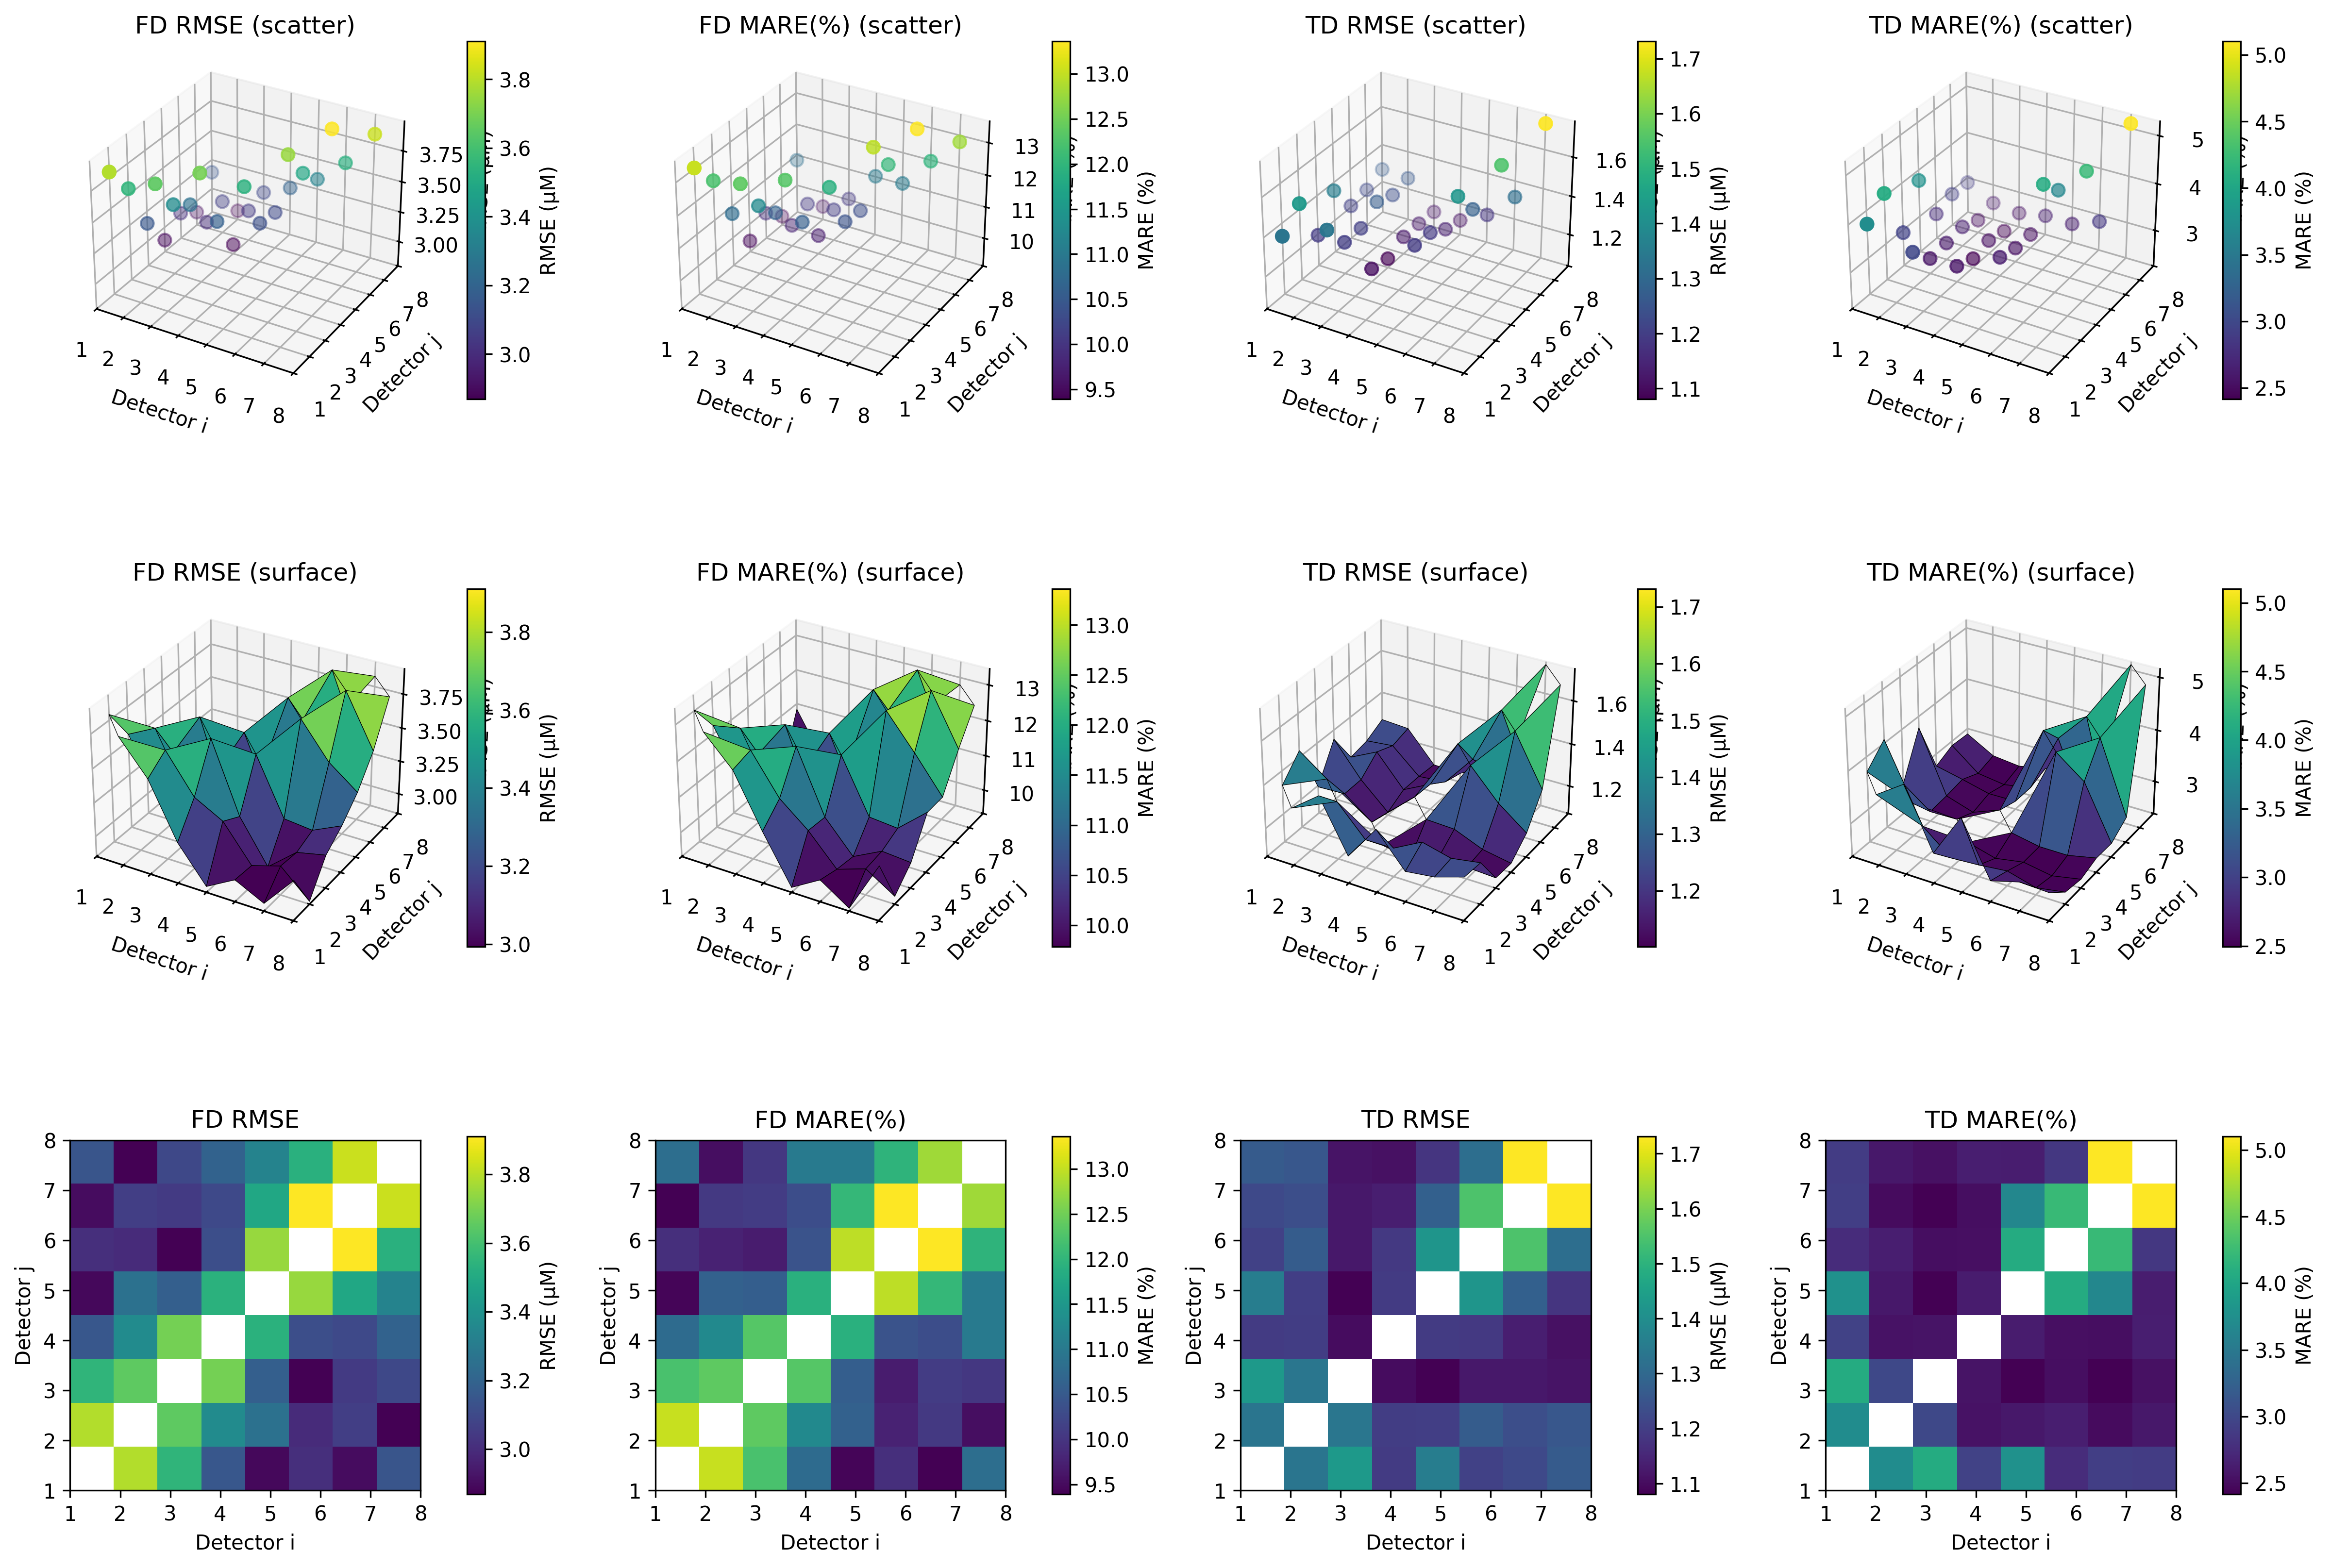

In [46]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.metrics import mean_squared_error

def compute_fd_td_metrics(folder_path):
    fd, td = {}, {}
    pat = re.compile(r'distance_(\d+)_hhb2_(FD|TD)\.csv', re.IGNORECASE)
    for fn in os.listdir(folder_path):
        m = pat.match(fn)
        if not m:
            continue
        key = int(m.group(1))
        domain = m.group(2).upper()
        df = pd.read_csv(os.path.join(folder_path, fn))
        y_pred, y_true = df['y_pred'].to_numpy(), df['y_test'].to_numpy()
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mare = np.mean(np.abs(y_pred - y_true) / np.abs(y_true)) * 100
        if domain == 'FD':
            fd[key] = {'RMSE': rmse, 'MARE(%)': mare}
        else:
            td[key] = {'RMSE': rmse, 'MARE(%)': mare}
    return dict(sorted(fd.items())), dict(sorted(td.items()))

def plot_3d_and_heatmaps(fd_metrics, td_metrics):
    """
    Creates a 3×4 figure:
      Row 1: 3D scatter FD-RMSE, FD-MARE, TD-RMSE, TD-MARE
      Row 2: 3D surface ...
      Row 3: 2D heatmap  ...
    X/Y axes run 1–8 everywhere.
    """
    domains = [('FD', fd_metrics), ('TD', td_metrics)]
    metrics = [('RMSE',    'RMSE (μM)'), ('MARE(%)', 'MARE (%)')]

    fig = plt.figure(figsize=(16, 12), dpi=300)
    idx = 1
    n = 8

    # ─── Row 1: 3D scatter ────────────────────────────────────
    for dom_name, dom_dict in domains:
        for met_key, met_label in metrics:
            X, Y, Z = [], [], []
            for key, vals in dom_dict.items():
                s = str(key)
                if len(s) != 2: continue
                i, j = int(s[0]), int(s[1])
                X.append(i); Y.append(j); Z.append(vals[met_key])

            ax = fig.add_subplot(3, 4, idx, projection='3d')
            sc = ax.scatter(X, Y, Z, c=Z, cmap='viridis', s=40)
            fig.colorbar(sc, ax=ax, shrink=0.6, pad=0.1, label=met_label)
            ax.set_title(f'{dom_name} {met_key} (scatter)')
            ax.set_xlabel('Detector i'); ax.set_ylabel('Detector j'); ax.set_zlabel(met_label)
            ax.set_xticks(range(1, n+1)); ax.set_yticks(range(1, n+1))
            ax.set_xlim(1, n); ax.set_ylim(1, n)
            idx += 1

    # ─── Row 2: 3D surface ────────────────────────────────────
    for dom_name, dom_dict in domains:
        for met_key, met_label in metrics:
            Zgrid = np.full((n, n), np.nan)
            for key, vals in dom_dict.items():
                s = str(key)
                if len(s) != 2: continue
                i, j = int(s[0]) - 1, int(s[1]) - 1
                Zgrid[i, j] = Zgrid[j, i] = vals[met_key]
            Xg, Yg = np.meshgrid(np.arange(1, n+1), np.arange(1, n+1))

            ax = fig.add_subplot(3, 4, idx, projection='3d')
            surf = ax.plot_surface(Xg, Yg, Zgrid, cmap='viridis', edgecolor='k', linewidth=0.3)
            fig.colorbar(surf, ax=ax, shrink=0.6, pad=0.1, label=met_label)
            ax.set_title(f'{dom_name} {met_key} (surface)')
            ax.set_xlabel('Detector i'); ax.set_ylabel('Detector j'); ax.set_zlabel(met_label)
            ax.set_xticks(range(1, n+1)); ax.set_yticks(range(1, n+1))
            ax.set_xlim(1, n); ax.set_ylim(1, n)
            idx += 1

    # ─── Row 3: 2D heatmap ────────────────────────────────────
    for dom_name, dom_dict in domains:
        for met_key, met_label in metrics:
            Zgrid = np.full((n, n), np.nan)
            for key, vals in dom_dict.items():
                s = str(key)
                if len(s) != 2: continue
                i, j = int(s[0]) - 1, int(s[1]) - 1
                Zgrid[i, j] = Zgrid[j, i] = vals[met_key]

            ax = fig.add_subplot(3, 4, idx)
            im = ax.imshow(
                Zgrid,
                origin='lower',
                extent=(1, n, 1, n),
                aspect='equal',
                cmap='viridis'
            )
            fig.colorbar(im, ax=ax, shrink=0.6, pad=0.1, label=met_label)
            ax.set_title(f'{dom_name} {met_key}')
            ax.set_xlabel('Detector i'); ax.set_ylabel('Detector j')
            ax.set_xticks(range(1, n+1)); ax.set_yticks(range(1, n+1))
            ax.set_xlim(1, n); ax.set_ylim(1, n)
            idx += 1

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    folder = '/content/drive/MyDrive/MCX_data/distance_2/'
    fd_metrics, td_metrics = compute_fd_td_metrics(folder)
    plot_3d_and_heatmaps(fd_metrics, td_metrics)
